In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
ls

drive/  sample_data/


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

## Importing Images

In [0]:
bs = 64

path = '/content/drive/My Drive/DamageDetection/DamageDetection/Data'
path2 = '/content/drive/My Drive/DamageDetection/DamageDetection/Data_test'

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, test = None, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

## Looking At Images

In [5]:
data.classes

['damage', 'no_damage']

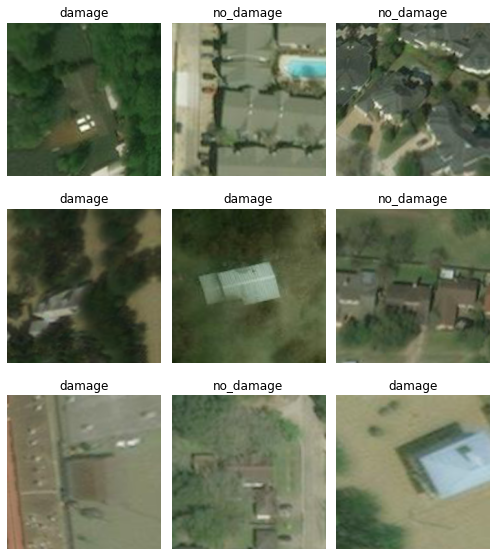

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['damage', 'no_damage'], 2, 10000, 2000)

## Training the model using Resnet34

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [9]:
learn.fit_one_cycle(24)

epoch,train_loss,valid_loss,accuracy,time
0,0.414495,0.197936,0.927000,32:27
1,0.301526,0.149376,0.942500,01:22
2,0.244332,0.113948,0.954500,01:22
3,0.176832,0.091445,0.961500,01:23
4,0.143828,0.076204,0.968500,01:20
5,0.126049,0.061872,0.970500,01:20
6,0.112986,0.064303,0.972500,01:19
7,0.098352,0.042603,0.984000,01:19
8,0.077041,0.045000,0.985000,01:19
9,0.071784,0.033811,0.989000,01:19


In [0]:
learn.save('stage-3')

In [80]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (10000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
damage,damage,damage,damage,damage
Path: /content/drive/My Drive/DamageDetection/DamageDetection/Data;

Valid: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
damage,damage,damage,damage,damage
Path: /content/drive/My Drive/DamageDetection/DamageDetection/Data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

Finding Learning Rate

In [0]:
learn.unfreeze()

In [136]:
learn.fit_one_cycle(1) # max_lr = 0.03

epoch,train_loss,valid_loss,accuracy,time
0,0.071896,0.034724,0.985000,01:34


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


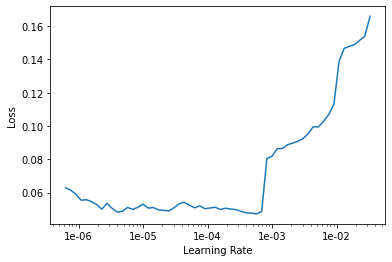

In [123]:
learn.lr_find()
learn.recorder.plot()

In [138]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.016786,0.019301,0.991500,01:27
1,0.013064,0.028977,0.992000,01:29
2,0.029226,0.039893,0.990000,01:28
3,0.024686,0.038714,0.989000,01:30
4,0.017518,0.021665,0.993000,01:29
5,0.015442,0.046628,0.992000,01:29
6,0.006059,0.031826,0.993500,01:29
7,0.005399,0.028129,0.994500,01:31
8,0.004305,0.031787,0.993000,01:30
9,0.002303,0.029678,0.994000,01:31


In [0]:
learn.save('stage-2')

In [19]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
damage,damage,damage,damage,damage
Path: /content/drive/My Drive/DamageDetection/DamageDetection/Data_test;

Valid: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
damage,damage,damage,damage,damage
Path: /content/drive/My Drive/DamageDetection/DamageDetection/Data_test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), st

In [72]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [73]:
losses

tensor([11.8222, 10.4992,  7.9537,  ..., -0.0000, -0.0000, -0.0000])

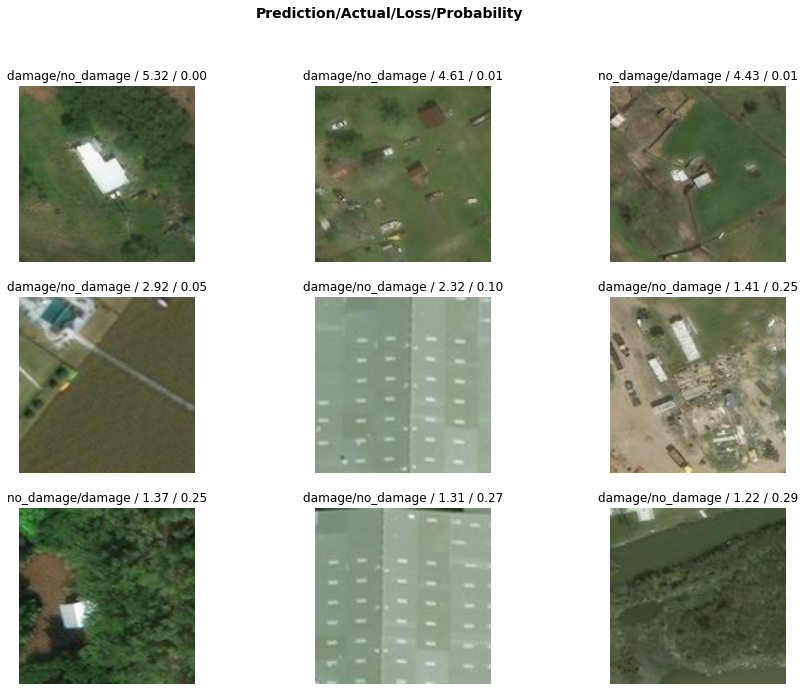

In [64]:
interp.plot_top_losses(9, figsize=(15,11))

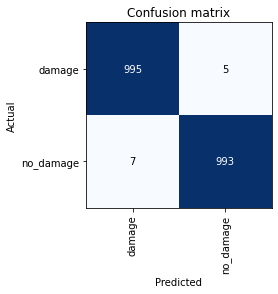

In [74]:
interp.plot_confusion_matrix()

## Calculating Score on Test Set

In [0]:
np.random.seed(32)
data_test = ImageDataBunch.from_folder(path2, train = 'train', valid = 'test', test = None, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [13]:
data_test.classes, data_test.c, len(data_test.train_ds), len(data_test.valid_ds)

(['damage', 'no_damage'], 2, 2000, 9000)

In [84]:
data_test.classes

['damage', 'no_damage']

In [0]:
learn.data = data_test


In [22]:
learn.validate(metrics=[accuracy])

[0.022422962, tensor(0.9947)]

In [23]:
interp1 = ClassificationInterpretation.from_learner(learn)

losses1,idxs1 = interp1.top_losses()

len(data_test.valid_ds)==len(losses1)==len(idxs1)

True

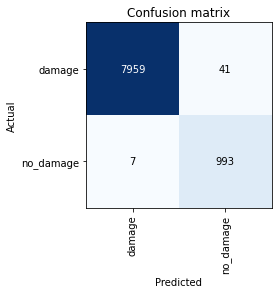

In [24]:
interp1.plot_confusion_matrix()

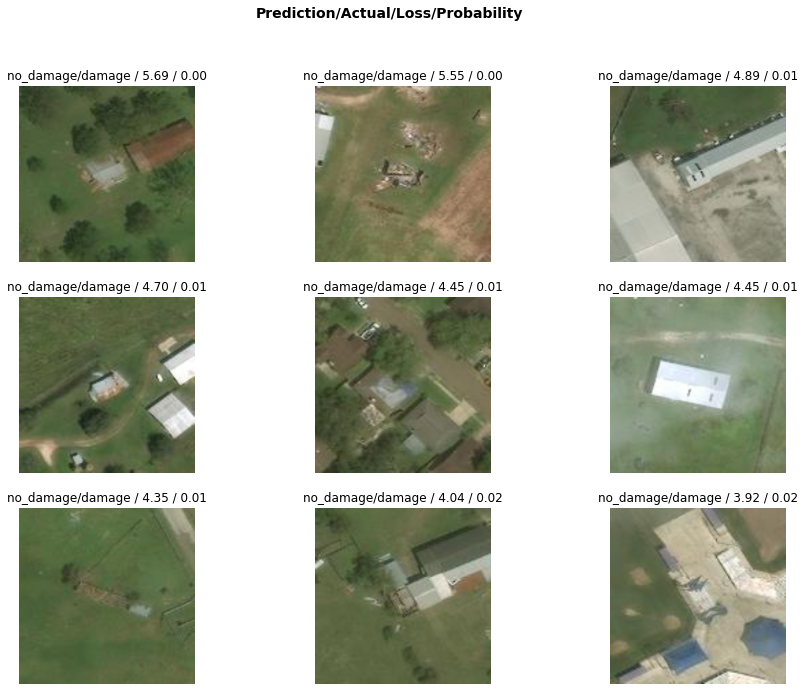

In [18]:
interp1.plot_top_losses(9, figsize=(15,11))

In [62]:
str(learn.metrics)

'[<function accuracy at 0x7f229f7a7b70>]'

In [74]:
# this will not yield good results because when the databunch is created
#even if the dataset has a test folder with labeled and distinguished subfolders
#like validation dataset(2 folders with names as damage, no_damage in test folder)
# then also the databunch stores no labels for the test set. SO all the images have label as 0
# and around half of the total images(in damage, no_damage folders in test folder) are actually 
# no_damage images, and out model predicts them correctly as 0 and rest as 1, but for the test 
# folder, there are no labels, all images have 0 as label, so all images predicted as 1 by our
#model are wrong and hence we get a 50% accuracy. 
learn.validate(dl = data.test_dl)

[3.7857308, tensor(0.4905)]

In [2]:
print(slice(1,2))

slice(1, 2, None)
